In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.float_format', '{:,.2f}'.format)


# Adjust path relative to this notebook (notebooks/ -> ../data/)
data_dir = Path('../data').resolve()
print('data_dir =', data_dir)

# find gas fee files
gas_files = sorted(data_dir.glob('ethereum_gas_*.csv'))

data_dir = /home/des/w/phd_thesis/data


In [2]:
# Read and concatenate gas fee CSVs
gas_dfs = []
for f in gas_files:
    df = pd.read_csv(f, parse_dates=['tx_date'])
    df['tx_date'] = pd.to_datetime(df['tx_date']).dt.date
    gas_dfs.append(df)

gas_df = pd.concat(gas_dfs, ignore_index=True)
gas_df = gas_df.sort_values('tx_date').reset_index(drop=True)
gas_df = gas_df.rename(columns={'tx_date':'date','total_tx_gas_cost_ETH':'gas_cost_eth'})
display(gas_df.head())

,date,gas_cost_eth,total_tx_gas_used
0,2020-01-01,300.16,37252588523
1,2020-01-02,289.91,37401007834
2,2020-01-03,341.81,42156338080
3,2020-01-04,275.79,38519976135
4,2020-01-05,267.59,38136631874


In [3]:
# Read Ether price CSV and normalise date column
eth_file = data_dir / 'EtherPrice.csv'
eth = pd.read_csv(eth_file)
# Date format in the file is like 7/30/2015 -> parse with month/day/year
eth['date'] = pd.to_datetime(eth['Date(UTC)'], format='%m/%d/%Y').dt.date
eth = eth[['date','Value']].copy()
eth = eth.rename(columns={'Value':'eth_price_usd'})
eth['eth_price_usd'] = eth['eth_price_usd'].astype(float)
display(eth.head())

,date,eth_price_usd
0,2015-07-30,0.00
1,2015-07-31,0.00
2,2015-08-01,0.00
3,2015-08-02,0.00
4,2015-08-03,0.00


In [4]:
# Merge on date and save result
merged = pd.merge(gas_df, eth, on='date', how='left')
merged['gas_cost_usd'] = merged['gas_cost_eth'] * merged['eth_price_usd']

# Convert date to datetime for filtering
merged['date'] = pd.to_datetime(merged['date'])
merged = merged[merged['date'] >= "2021-01-01"]

out_file = data_dir / 'merged_gas_eth.csv'
display(merged.head())

,date,gas_cost_eth,total_tx_gas_used,eth_price_usd,gas_cost_usd
366,2021-01-01,"5,188.67",80038891441,730.60,"3,790,844.75"
367,2021-01-02,"8,012.07",80948469861,774.90,"6,208,549.39"
368,2021-01-03,"13,011.09",78955134702,978.69,"12,733,827.01"
369,2021-01-04,"20,121.69",79464427883,"1,043.16","20,990,141.42"
370,2021-01-05,"10,958.67",79844614999,"1,103.19","12,089,491.00"


In [5]:
# Calculate and print daily average gas cost
daily_average_gas_cost = merged['gas_cost_usd'].mean()
print(f"Daily Average Gas Cost (USD): ${daily_average_gas_cost:,.2f}")

Daily Average Gas Cost (USD): $10,739,268.41


In [6]:
# Convert date to datetime for year extraction
merged['year'] = pd.to_datetime(merged['date']).dt.year

# Group by year and calculate total gas cost in USD
yearly_summary = merged.groupby('year')[['gas_cost_usd', 'gas_cost_eth', 'total_tx_gas_used']].sum().reset_index()
yearly_summary.columns = ['Year', 'Total Gas Cost (USD)', 'Total Gas Cost (ETH)', 'Total Gas Usage']

# Show full numbers (no scientific notation) with two decimals
display(yearly_summary)

,Year,Total Gas Cost (USD),Total Gas Cost (ETH),Total Gas Usage
0,2021,"9,914,610,033.51","3,446,698.30",33525740564200
1,2022,"4,298,421,689.01","1,766,038.69",36772983014963
2,2023,"2,406,683,232.13","1,309,054.54",39317829018806
3,2024,"2,469,410,666.40","792,859.60",39640719448412
4,2025,"520,778,503.47","171,820.75",54101417224394


In [7]:
# Display the total gas cost in USD across all years
total_gas_cost = yearly_summary['Total Gas Cost (USD)'].sum()
print(f"Total Gas Cost (USD) across all years: ${total_gas_cost:,.2f}")



Total Gas Cost (USD) across all years: $19,609,904,124.52


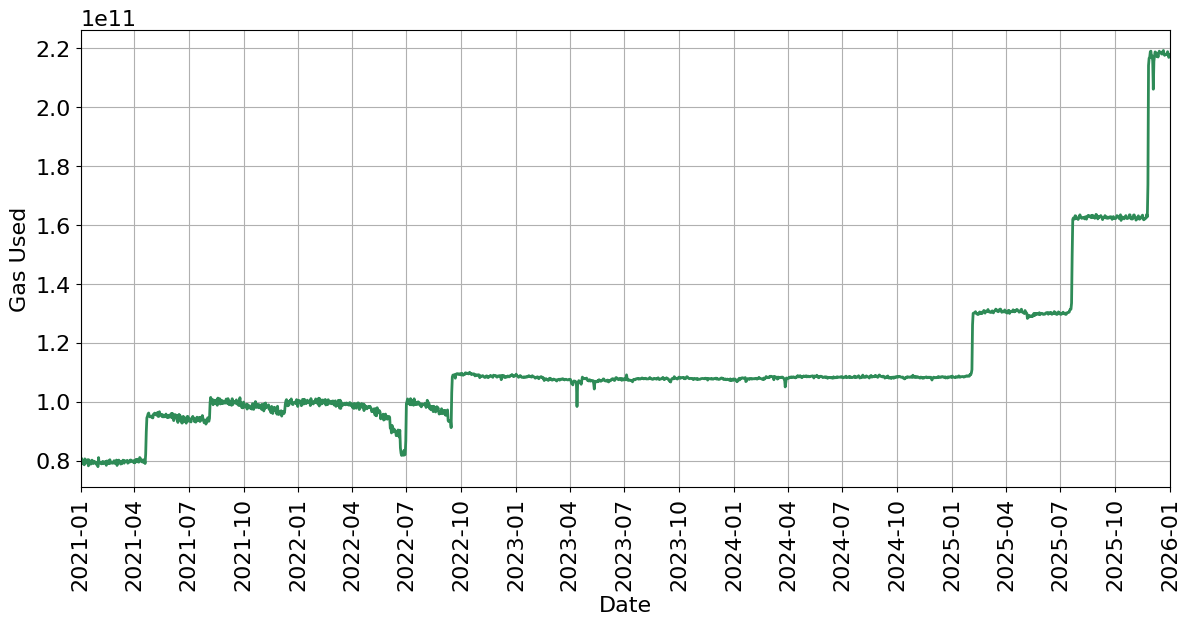

In [9]:
from matplotlib.dates import MonthLocator, DateFormatter

# Filter data from 2020-01-01 to 2025-01-01
merged_filtered = merged.copy()
merged_filtered['date'] = pd.to_datetime(merged_filtered['date'])
merged_filtered = merged_filtered[(merged_filtered['date'] >= '2021-01-01') & (merged_filtered['date'] <= '2026-01-01')]

# Set font sizes to match report style
plt.rcParams.update({'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.labelsize': 16})

# Define green colors
light_green = '#8dd3c7'
dark_green = '#2e8b57'

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(merged_filtered['date'], merged_filtered['total_tx_gas_used'], color=dark_green, linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Gas Used')
ax.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2026-01-01'))
ax.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()

# Show labels every 3 months
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.savefig(data_dir / 'gasUsage2020To2026.pdf', format='pdf', bbox_inches='tight')
